In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOLDVIR as HALOVI
from complementary_models import HALOLDVAER as HALOVAE
import scanpy as sc
import scvi
import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
### test whole data with RNA only 
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'latent_time']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :14583


In [4]:
model.train(max_epochs=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=10 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/10:  40%|████      | 4/10 [00:09<00:13,  2.31s/it, loss=1.58e+04, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
model = model.load("linearModel", adata_mvi)

INFO     File linearModel/model.pt already downloaded                                        
n_genes :14583


In [5]:
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=100)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [03:54<00:00,  2.34s/it, loss=1.07e+05, v_num=1]


In [6]:
model.module.set_train_params(expr_train=True, acc_train=False)
model.module.set_finetune_params(0)
model.train(max_epochs=20)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=20 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:44<00:00,  2.21s/it, loss=9.76e+03, v_num=1]


In [7]:
model.module.set_train_params(expr_train=False, acc_train=True)
model.module.set_finetune_params(0)
model.train(max_epochs=20)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=20 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it, loss=2.25e+04, v_num=1]


In [11]:
model.module.set_train_params(expr_train=True, acc_train=True)
model.module.set_finetune_params(2)
model.train(max_epochs=50)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=50 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [02:44<00:00,  3.29s/it, loss=1.85e+05, v_num=1]


In [6]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

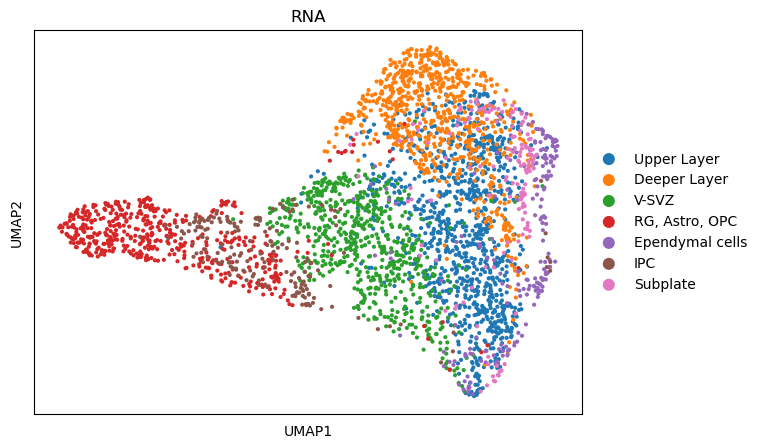

In [7]:
import matplotlib.pyplot as plt
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'RNA')
plt.show()

In [14]:
from complementary_models import torch_infer_nonsta_dir


latent_atac_indep = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

score3, _, _ = torch_infer_nonsta_dir(latent_atac_indep, latent_expr_indep, times)
score4, _, _ = torch_infer_nonsta_dir(latent_expr_indep, latent_atac_indep, times)
score3 - score4

tensor(-0.0002, device='cuda:0', dtype=torch.float64)

In [8]:
loadmatrix = model.module.get_loadings()

In [9]:
loadmatrix.shape

(14583, 10)

In [40]:
loadmatrix_dep = np.abs(np.sum(loadmatrix[:, :5], axis=1))
loadmatrix_indep = np.abs(np.sum(loadmatrix[:, 5:], axis=1))
loadatrix = np.concatenate([[np.abs(loadmatrix_dep)], [np.abs(loadmatrix_indep)]], axis=0)

In [41]:
print(max(loadmatrix_dep), min(loadmatrix_dep))

1.718332 0.0001580459


In [42]:
dep_index1 =  np.where(loadmatrix_dep > 0.5)
dep_index2 =  np.where(loadmatrix_indep < 0.01)

In [43]:
## dependent genes
list(set(dep_index1[0]) & set(dep_index2[0]))

[12293,
 3336,
 143,
 4243,
 4628,
 9628,
 10270,
 13599,
 8223,
 9125,
 1835,
 12346,
 9790,
 7998,
 11980,
 10703,
 9431,
 5721,
 6877,
 9571,
 9446,
 13931,
 13678,
 9071,
 9968,
 7038]

In [44]:
dep_index1 =  np.where(loadmatrix_indep > 0.3)
dep_index2 =  np.where(loadmatrix_dep < 0.01)

In [45]:
## independent genes

list(set(dep_index1[0]) & set(dep_index2[0]))

[3651, 488, 12205, 9680, 944, 14064, 13272, 11193]

In [15]:
x = np.array([[0, 10, 20], [20, 30, 40]])
print("Values bigger than 10 =", x[x>10])
print("Their indices are ", np.nonzero(x > 10))


Values bigger than 10 = [20 20 30 40]
Their indices are  (array([0, 1, 1, 1]), array([2, 0, 1, 2]))


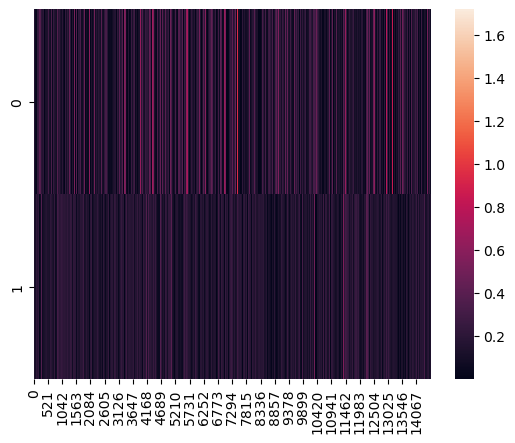

In [23]:
import seaborn as sns

sns.heatmap(loadatrix)
plt.show()

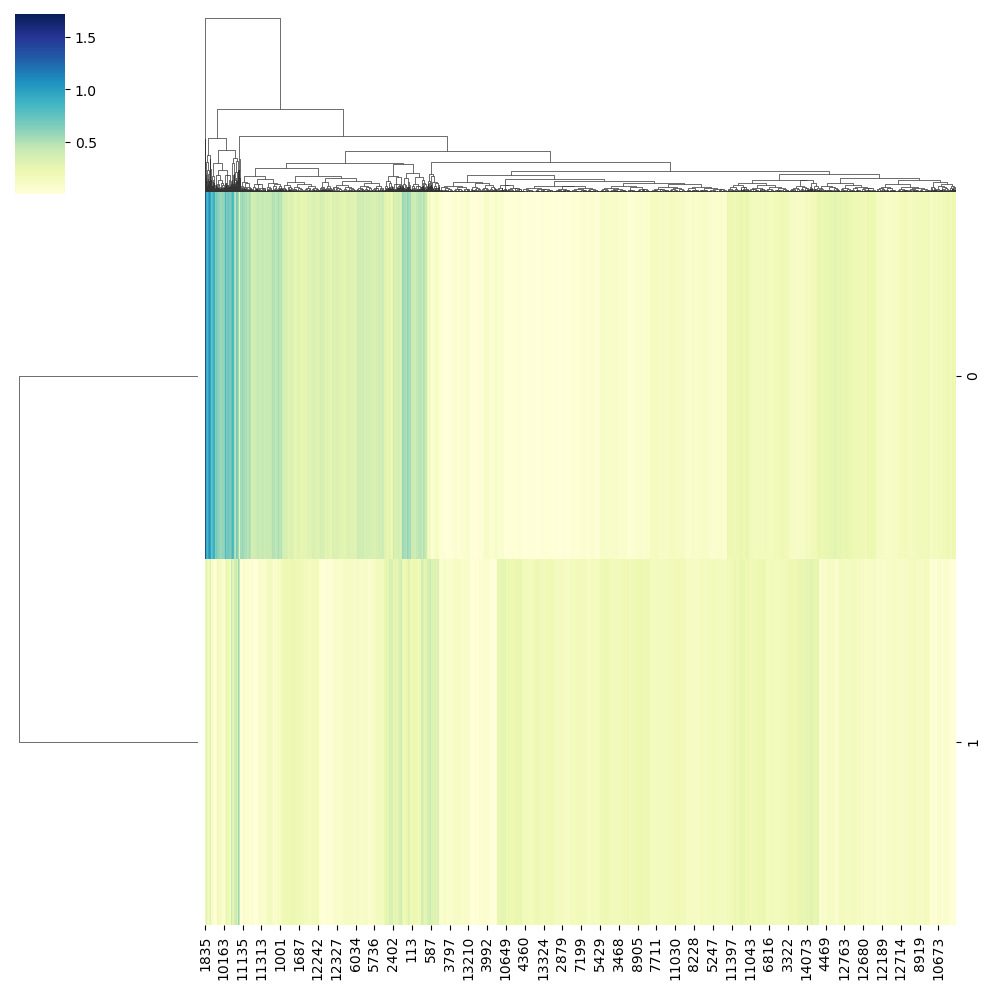

In [28]:
p = sns.color_palette('YlGnBu', as_cmap=True)

sns.clustermap(loadatrix, cmap= p)